# Exercises Week 10: Simulating stochasticity in gene expression

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2022-2023

$$\require{mhchem}$$  
$$\require{dcolumn}$$
$$\require{longtable}$$
$$\require{array}$$
$$\require{multirow}$$

In today's exercise session, we will simulate the chemical master equation (CME) of two processes using the Gillespie algorithm.  
In *Exercise 1*, you will consider a simple birth-death process and study its properties.  
In *Exercise 2*, you will simulate a chemical oscillator known as the *Brusselator*.

# Exercise 1: Probabilistic description of the Birth-death process
Let's consider a simple birth-death process in which a species $x$ is produced at a rate $s$ and degraded at a rate $k$:  

\begin{equation*}
\frac{dx}{dt} = s - kx 
\end{equation*}
The four possible events can be described as follow:
\begin{eqnarray*}
&&n-1 \longrightarrow n \textrm{ with rate } s \\
&&n \longrightarrow n+1 \textrm{ with rate } s \\
&&n+1 \longrightarrow n  \textrm{ with rate } k(n+1) \\
&&n \longrightarrow n-1 \textrm{ with rate } kn
\end{eqnarray*}

From those events, we can describe the master equation which gives the probability $P(n,t)$ to have $n$ molecules of the compound at time $t$:  

\begin{equation*}
\frac{dP(n,t)}{dt} = sP(n-1,t) + k(n+1)P(n+1,t) - sP(n,t) - knP(n,t)
\end{equation*}

### Question 1
You will simulate the birth-death process using the Gillespie algorithm code provided below.
1. Study the Gillespie code and describe its main steps. 
2. Fill the missing parts (annoted with "FILL HERE").
3. Run the simulation multiple times and describe the results.
4. Verify that the steady-state distribution of the molecule $n$ follows a Poisson distribution.
5. How are ($s$, $k$) changing this distribution?

### Answer 1
**1.**  
       a. Initialize the state of the system.  
       b. Randomly pick the time of the next reaction (from an exponential with rate=the sum of all reaction rates).  
       c. Randomly pick which reaction has occured (proportially to the rate of each reaction).  
       d. Update the state of the system.  
       e. Iterate b. to d.  
**2.** See code below  
**3.** Due to the stochastic nature of the algorithm, we get different trajectories at each run.  
**4.** You can set the $\lambda$ to the predicted mean number of molecules at steady-state.   
**5.** $\lambda = \frac{s}{k}$

In [1]:
#import librairies
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.integrate import odeint
from scipy.special import gammaln

#### Gillespie algorithm for the birth-death model:

In [2]:
n = [0] # initial condition
t = [0]
s = 20 # synthesis rate, here in molecules per unit time, not concentration per unit time.
k = 1  # degradation rate in hr^-1
t_end = 100 # total time in hr (should be choosen according to the half-life time)

while t[-1] < t_end:
     
    current_n = n[-1]
    rates = [s, k * current_n]
    rates_tot = sum(rates)
    
    #pick the next time interval
    dt = np.random.exponential(scale=1/rates_tot) # scale is 1/lambda
    t.append(t[-1] + dt)
    
    rand_uniform = np.random.random()
    
    #simplified version for just two reactions
    #production
    if rand_uniform <= (rates[0] / rates_tot):
         n.append(current_n + 1) 
        
    #degradation
    else:
         n.append(current_n - 1) 
     

#### Plot the trajectory and histogram

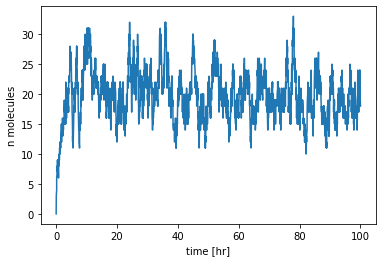

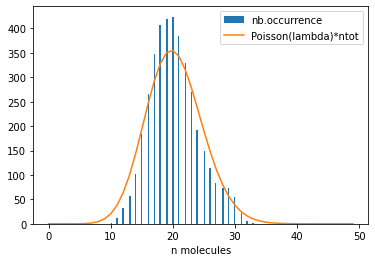

In [3]:
plt.plot(t,n)
plt.xlabel("time [hr]")
plt.ylabel("n molecules")
plt.show()   

#remove a suitable transient and plot the histogram
plt.hist(n[50:],100, label='nb.occurrence')
ntot=len(n[50:])

# get random numbers from a poisson distribution
def Poisson(lam, n):
    logp=n*np.log(lam)-lam-gammaln(n+1)
    return np.exp(logp)
    

lam=np.mean(n[50:]) # Change lambda to fit the histogramm
nn=np.arange(50)
p=Poisson(lam, nn)
p=p*ntot
plt.plot(nn, p, label='Poisson(lambda)*ntot')
plt.xlabel("n molecules")

plt.legend()
plt.show()

# Exercise 2: The Brusselator

The Brusselator (proposed in 1967 in Brussels by R. Lefever I. Prigogine et G. Nicolis) describes a chemical oscillator governed by the following chemical reactions:

$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { reaction } & \text { reaction rate} & \text { dX/dt } & \text { dY/dt } \\
\ce{\emptyset ->[k_1] X} & v_1=k_1 & +v_1 & 0 \\
\ce{X ->[k_2] Y} & v_2=k_2 X & -v_2 & +v_2\\
\ce{2X + Y ->[k_3] 3X} & v_3=k_3X^2Y & +v_3 & -v_3 \\
\ce{X ->[k_4]\emptyset} & v_4=k_4X & -v_4 & 0 \\
\hline
\end{array}
\end{aligned}
$$

The determinisitic equations for the concentrations $X$ and $Y$ are given by:

\begin{eqnarray*}
&&\frac{dX}{dt} = k_1 -k_2X + k_3X^2Y -k_4X \\
&&\frac{dY}{dt} = k_2X -k_3X^2Y
\end{eqnarray*}

For example, the unit of $k_1$ is concentration over time. In the stochastic description of this process, we have to associate to each reaction a transition probability:

$$
\begin{aligned}
&\begin{array}{ccc}
\hline \hline \text { reaction } & \text {transition rate}\\
\ce{n ->[r_1] n +1} & r_1=k_1 \Omega\\
\ce{n ->[r_2] m} & r_2=k_2 n\\
\ce{2n + m ->[r_3] 3n} & r_3=k_3n(n-1)m\Omega^{-2}\\
\ce{n ->[r_4]n-1} & r_4=k_4 n\\
\hline
\end{array}
\end{aligned}
$$

with $\Omega$ the system size (or volume). Note the dependencies of the different reaction rates on $\Omega$, which ensures that the transition rates are in the right units (1/time).

### Question 1
1. Using the code below, simulate the deterministic system after filling the missing parts (annotated with "FILL HERE").
2. Plot X and Y in function of t. Describe how the parameters affect the oscillatory pattern.
3. Plot the phase portrait (X vs. Y) and describe how the parameters affect the limit cycle.

### Answer 1
**1.**  See code below.  
**2.**  Depending on the parameters, the system can oscillate (*e.g.* parameters: [1, 3, 1, 1]) or reach steady-state (*e.g.* parameters: [1, 1.7, 1, 1]). $k_2$ affects the period of the oscillation (increasing $k_2$ increases the period).  
**3.**  Related to the situations described above, the system can reach a limit cycle or a stable fixed point depending on the parameters.   

#### Deterministic simulation of the Brusselator, limit cycle

In [4]:
## function definition
def func(y, t, k1, k2, k3, k4):
    X, Y = y
    return [k1 - k2 * X + k3 * (X ** 2) * Y - k4 * X, k2 * X - k3 * (X ** 2) * Y]

def simulation(func, par, x0 = None, t = None):
    k_1=par[0]
    k_2=par[1]
    k_3=par[2]
    k_4=par[3]

    xx=odeint(func, x0, t, args=(k_1,k_2,k_3,k_4))
    return xx

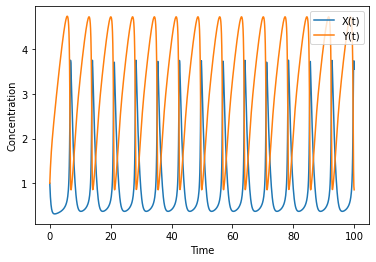

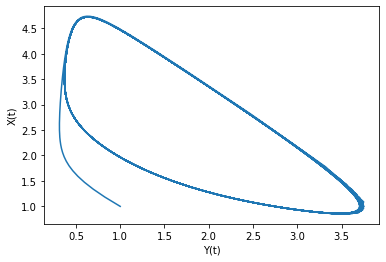

In [5]:
#initial conditions
x0=[1,1] #[X, Y]
par=[1,3,1,1]
time = np.linspace(0,100,1001)
xx=simulation(func, par, x0, time)

plt.plot(time, xx[:,0],label = 'X(t)')
plt.plot(time, xx[:,1],label = 'Y(t)')
plt.ylabel('Concentration')
plt.xlabel('Time')
plt.legend(loc='upper right')
plt.show()
plt.plot(xx[:,0],xx[:,1])
plt.ylabel('X(t)')
plt.xlabel('Y(t)')

plt.show()

#### Deterministic simulation of the Brusselator, stable fixed point

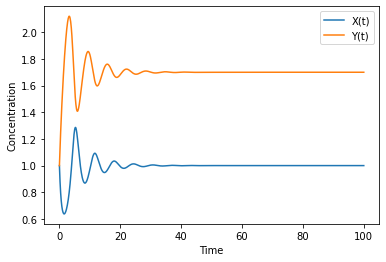

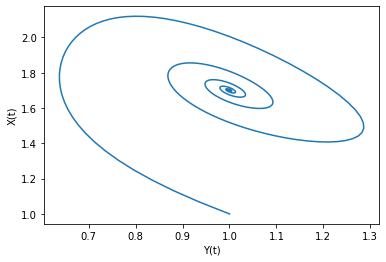

In [6]:
#initial conditions
x0=[1,1] #[X, Y]
par=[1,1.7,1,1]
time = np.linspace(0,100,1001)
xx=simulation(func, par, x0, time)

plt.plot(time, xx[:,0],label = 'X(t)')
plt.plot(time, xx[:,1],label = 'Y(t)')
plt.ylabel('Concentration')
plt.xlabel('Time')
plt.legend(loc='upper right')
plt.show()
plt.plot(xx[:,0],xx[:,1])
plt.ylabel('X(t)')
plt.xlabel('Y(t)')

plt.show()

### Question 2
Simulate the Brusselator using the Gillespie algorithm code for two species provided below.
1. Study the Gillespie code and describe its main steps. 
2. Fill the missing parts (annoted with "FILL HERE") to simulate the system. 
3. Run the simulation and describe the results. In particular, plot X and Y in function of time as well as the phase portrait X vs. Y. Compare with the deterministic results.
4. How are the parameters affecting the evolution of X and Y, in particular the system size $\Omega$?  
5. Optional: how does the number of reactions scale with $\Omega$?

### Answer 2
1. The algorithm is similar than in **Question 1**, except that we are using the cumulative sum of the rates to select the next reaction (which is equivalent).
2. See code below.
3. We see that the stochastic trajectories are converging around the deterministic limit cycle or stable fixed point. The behavior can be different between the two approaches due to the noise in the stochastic model if we set parameters near the bifurcation between the limit cycle and the stable fixed point.

In [7]:
def run_gillespie(n0, m0, t_end, omega, k1, k2, k3, k4):
    # note that we use python lists [] to store the trajectories
    #
    # This simulation can take a bit of time, so try with short
    # t_end first until the code works, or with a low omega

    n = [n0]
    m = [m0]
    t = [0]

    #the stochiometric matrix S
    S = np.array([[1, 0], [-1, 1], [1, -1], [-1, 0]])

    t_end = t_end #total time
    omega = omega #system size

    k1 = k1
    k2 = k2
    k3 = k3
    k4 = k4

    while t[-1] < t_end:
        
        current_n = n[-1]
        current_m = m[-1]
        rates = [k1*omega, current_n*k2, 
                 current_n*(current_n-1)*current_m*k3/(omega**2), 
                 k4*current_n]
    
        rates_tot = sum(rates)
        rates_cumsum = np.cumsum(rates)/rates_tot
    
        #pick the time of the next reaction
        dt = np.random.exponential(scale=1.0/rates_tot) # scale is 1/lambda
        t.append(t[-1] + dt)
    
        #pick the reaction
        rand = np.random.random()
        i=0
        while rand >= rates_cumsum[i]:
            i=i+1;
        chosen_react=i
    
        n.append(current_n + S[chosen_react,0])  
        m.append(current_m + S[chosen_react,1])
    
    return n, m, t

#### Deterministic and stochastic simulation of the Brusselator, stable fixed point

In [8]:
k1=k3=k4=1
k2=1.5
omega=100
t_end=100
x0=[1,1]

#Deterministic
par=[k1,k2,k3,k4]
time = np.linspace(0,t_end,1001)
xx=simulation(func, par, x0, time)

#Stochastic 
[n, m, t]=run_gillespie(x0[0]*omega,x0[1]*omega, t_end, omega, k1, k2, k3, k4)

#### Plot the trajectory and the phase portrait

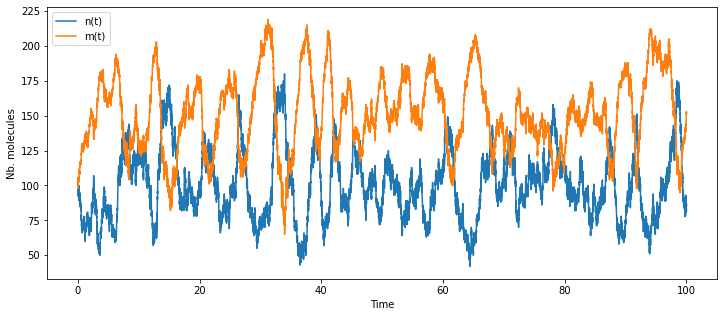

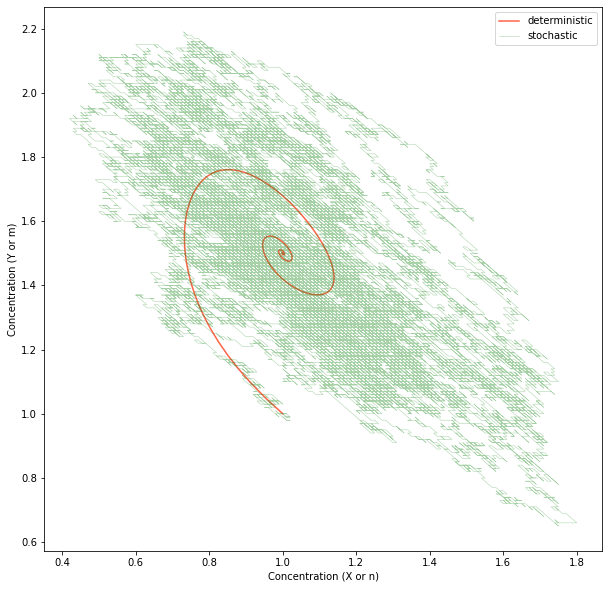

In [9]:
plt.figure(figsize=(12,5))
plt.plot(t, n,label = 'n(t)')
plt.plot(t, m,label = 'm(t)')
plt.xlabel('Time')
plt.ylabel('Nb. molecules')

plt.legend()
plt.show()
plt.figure(figsize = (10,10))
plt.plot(xx[:,0],xx[:,1],label='deterministic', color='tomato', alpha=1)
plt.plot(np.array(n)/omega,np.array(m)/omega, label='stochastic', color='forestgreen', linewidth=.5, alpha=0.4)

plt.xlabel('Concentration (X or n)')
plt.ylabel('Concentration (Y or m)')

plt.legend()
plt.show()

#### Deterministic and stochastic simulation of the Brusselator, limit cycle

In [10]:
k1=k3=k4=1
k2=3
omega=100
t_end=100
x0=[1,1]
#Deterministic

par=[k1,k2,k3,k4]
time = np.linspace(0,t_end,1001)
xx=simulation(func, par, x0, time)
#Stochastic 
[n, m, t]=run_gillespie(x0[0]*omega,x0[1]*omega, t_end, omega, k1, k2, k3, k4)

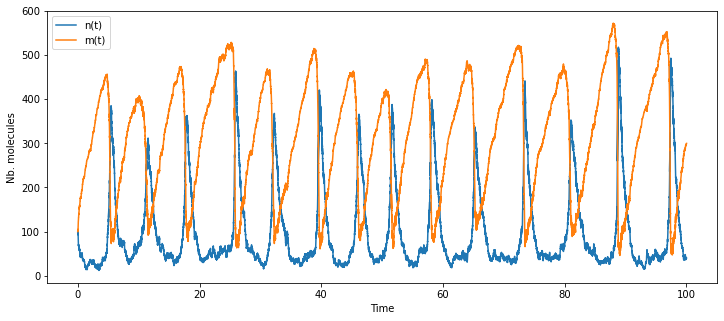

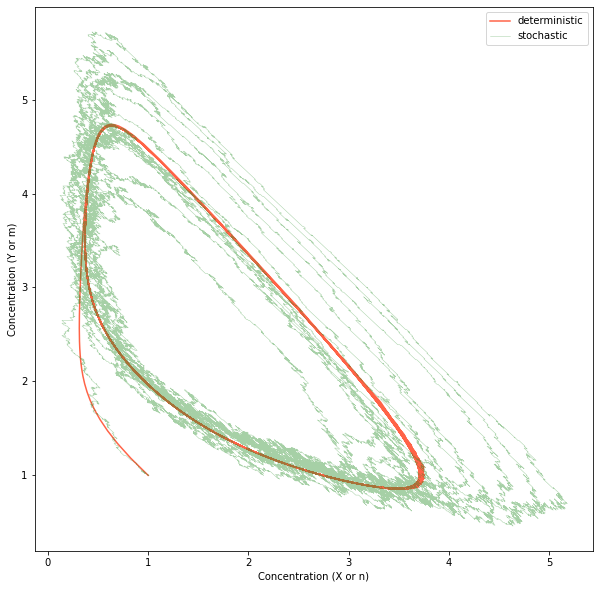

In [11]:
plt.figure(figsize=(12,5))
plt.plot(t, n,label = 'n(t)')
plt.plot(t, m,label = 'm(t)')
plt.xlabel('Time')
plt.ylabel('Nb. molecules')

plt.legend()
plt.show()
plt.figure(figsize = (10,10))
plt.plot(xx[:,0],xx[:,1],label='deterministic', color='tomato', alpha=1)
plt.plot(np.array(n)/omega,np.array(m)/omega, label='stochastic', color='forestgreen', linewidth=.5, alpha=0.4)

plt.xlabel('Concentration (X or n)')
plt.ylabel('Concentration (Y or m)')

plt.legend()
plt.show()

**4.** The system size $\Omega$ tunes the noise. A large $\Omega$ reduces the relative noise in the system.

In [12]:
k1=k3=k4=1
k2=3
omega=1000
t_end=100
x0=[1,1]
#Deterministic

par=[k1,k2,k3,k4]
time = np.linspace(0,t_end,1001)
xx=simulation(func, par, x0, time)
#Stochastic 
[n, m, t]=run_gillespie(x0[0]*omega,x0[1]*omega, t_end, omega, k1, k2, k3, k4)

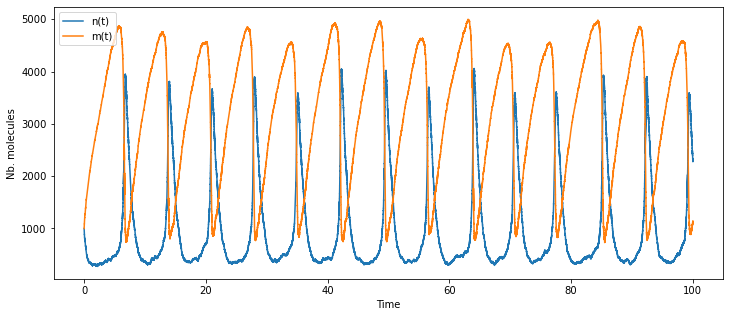

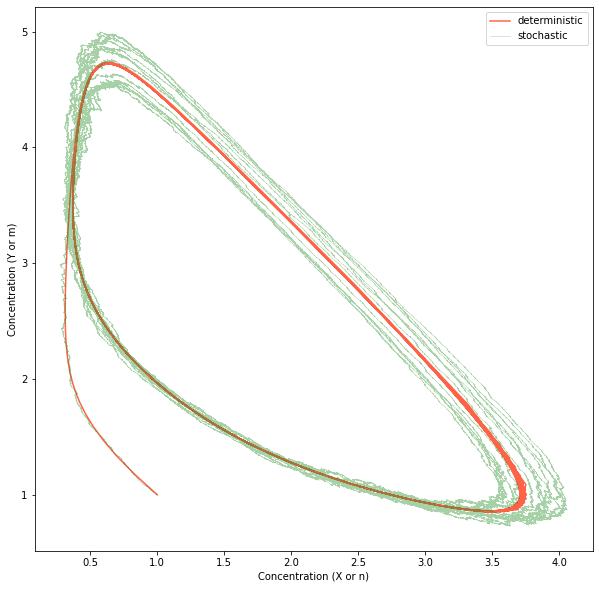

In [13]:
plt.figure(figsize=(12,5))
plt.plot(t, n,label = 'n(t)')
plt.plot(t, m,label = 'm(t)')
plt.xlabel('Time')
plt.ylabel('Nb. molecules')

plt.legend()
plt.show()
plt.figure(figsize = (10,10))
plt.plot(xx[:,0],xx[:,1],label='deterministic', color='tomato', alpha=1)
plt.plot(np.array(n)/omega,np.array(m)/omega, label='stochastic', color='forestgreen', linewidth=.5, alpha=0.4)

plt.xlabel('Concentration (X or n)')
plt.ylabel('Concentration (Y or m)')

plt.legend()
plt.show()

**5.** Empirically, the running time scales roughly exponentially with the system size $\Omega$.